# Joint Song + Poem Clustering (Aligned Labels)

This notebook consumes the exported clusters from `modality_alignment.py`, merges them with the original metadata, and provides quick summaries/visualizations without re-running the full alignment pipeline.

In [46]:
%pip install umap-learn

from __future__ import annotations

import json
import re
from collections import Counter
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.linalg import fractional_matrix_power
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from umap import UMAP

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:  # pragma: no cover - optional dependency
    SentimentIntensityAnalyzer = None

try:
    from wordcloud import WordCloud
except ImportError:  # pragma: no cover - optional dependency
    WordCloud = None

sns.set_theme(style="whitegrid", context="talk")
%matplotlib inline


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [47]:

PROJECT_ROOT = Path('/Users/shirleyzhang/Desktop/CS229/cs229FinalProject')
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_RAW = PROJECT_ROOT / "data" / "raw"

SONG_EMBED_PATH = DATA_PROCESSED / "mpnet_embeddings_songs.npy"
POEM_EMBED_PATH = DATA_PROCESSED / "mpnet_embeddings_poems.npy"
SONG_META_PATH = DATA_PROCESSED / "combined_songs_large_fixed.json"
POEM_META_PATH = DATA_RAW / "poetrydb_poems.json"
LABELS_PATH = DATA_PROCESSED / "aligned_cluster_labels.csv"

print(f"Project root: {PROJECT_ROOT}")
print(f"Labels CSV: {LABELS_PATH}")
if not LABELS_PATH.exists():
    raise FileNotFoundError("Please run modality_alignment.py to produce aligned_cluster_labels.csv")

Project root: /Users/shirleyzhang/Desktop/CS229/cs229FinalProject
Labels CSV: /Users/shirleyzhang/Desktop/CS229/cs229FinalProject/data/processed/aligned_cluster_labels.csv


In [48]:

songs_embeddings = np.load(SONG_EMBED_PATH)
poems_embeddings = np.load(POEM_EMBED_PATH)
combined_embeddings = np.vstack([songs_embeddings, poems_embeddings])

with SONG_META_PATH.open("r", encoding="utf-8") as fp:
    songs_meta = json.load(fp)["items"]

with POEM_META_PATH.open("r", encoding="utf-8") as fp:
    poems_meta = json.load(fp)["items"]

labels_df = pd.read_csv(LABELS_PATH)
print(f"Songs embeddings shape: {songs_embeddings.shape}")
print(f"Poems embeddings shape: {poems_embeddings.shape}")
print(f"Labels rows: {len(labels_df)} | Columns: {list(labels_df.columns)}")

Songs embeddings shape: (3000, 768)
Poems embeddings shape: (3413, 768)
Labels rows: 6413 | Columns: ['modality', 'index', 'title', 'creator', 'cluster', 'cluster_prob']


In [49]:

APPLY_CORAL = True  # set to False if you ran modality_alignment.py without --apply-coral
UMAP_N_COMPONENTS = 2
UMAP_N_NEIGHBORS = 80
UMAP_MIN_DIST = 0.05


def per_modality_zscore(songs: np.ndarray, poems: np.ndarray):
    def _z(x):
        mean = x.mean(axis=0, keepdims=True)
        std = x.std(axis=0, keepdims=True) + 1e-6
        return (x - mean) / std
    return _z(songs), _z(poems)


def remove_modality_direction_lr(songs: np.ndarray, poems: np.ndarray):
    combined = np.vstack([songs, poems])
    labels = np.concatenate([
        np.zeros(len(songs), dtype=np.int32),
        np.ones(len(poems), dtype=np.int32),
    ])
    clf = LogisticRegression(max_iter=2000, solver="lbfgs")
    clf.fit(combined, labels)
    direction = clf.coef_[0]
    norm = np.linalg.norm(direction)
    if norm == 0:
        return songs, poems
    unit = direction / norm
    songs_adj = songs - (songs @ unit)[:, None] * unit
    poems_adj = poems - (poems @ unit)[:, None] * unit
    return songs_adj, poems_adj


def coral_align(reference: np.ndarray, target: np.ndarray, epsilon: float = 1e-3):
    ref_cov = np.cov(reference, rowvar=False) + epsilon * np.eye(reference.shape[1])
    tgt_cov = np.cov(target, rowvar=False) + epsilon * np.eye(target.shape[1])
    ref_sqrt = fractional_matrix_power(ref_cov, 0.5).real
    tgt_inv_sqrt = fractional_matrix_power(tgt_cov, -0.5).real
    target_centered = target - target.mean(axis=0, keepdims=True)
    aligned = target_centered @ tgt_inv_sqrt @ ref_sqrt
    aligned += reference.mean(axis=0, keepdims=True)
    return aligned.astype(np.float32)

songs_z, poems_z = per_modality_zscore(songs_embeddings, poems_embeddings)
songs_aligned, poems_aligned = remove_modality_direction_lr(songs_z, poems_z)
if APPLY_CORAL:
    poems_aligned = coral_align(songs_aligned, poems_aligned)

aligned_embeddings = np.vstack([songs_aligned, poems_aligned])
print(f"Aligned embedding matrix: {aligned_embeddings.shape}")

umap_model = UMAP(
    n_components=UMAP_N_COMPONENTS,
    metric="cosine",
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    random_state=42,
)
aligned_umap = umap_model.fit_transform(aligned_embeddings)
print(f"UMAP embedding shape: {aligned_umap.shape}")

Aligned embedding matrix: (6413, 768)


/Users/shirleyzhang/Desktop/CS229/cs229FinalProject/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (6413, 2)


In [50]:

def build_song_dataframe(items: List[Dict[str, object]]) -> pd.DataFrame:
    records = []
    for idx, song in enumerate(items):
        records.append({
            "modality": "song",
            "index": idx,
            "title": song.get("title"),
            "creator": song.get("artist") or song.get("spotify_artist_name"),
            "match_score": song.get("match_score"),
            "popularity": song.get("popularity"),
            "text": song.get("lyrics", "") or "",
        })
    return pd.DataFrame(records)


def build_poem_dataframe(items: List[Dict[str, object]]) -> pd.DataFrame:
    records = []
    for idx, poem in enumerate(items):
        lines = poem.get("lines") or []
        if isinstance(lines, list):
            text = "\n".join(lines)
        else:
            text = str(lines)
        records.append({
            "modality": "poem",
            "index": idx,
            "title": poem.get("title"),
            "creator": poem.get("author"),
            "linecount": poem.get("linecount"),
            "text": text,
        })
    return pd.DataFrame(records)


def attach_labels(df: pd.DataFrame, modality: str) -> pd.DataFrame:
    subset = labels_df[labels_df["modality"] == modality][["index", "cluster", "cluster_prob"]]
    merged = df.merge(subset, on="index", how="left")
    merged = merged.sort_values("index").reset_index(drop=True)
    return merged

songs_df = attach_labels(build_song_dataframe(songs_meta), "song")
poems_df = attach_labels(build_poem_dataframe(poems_meta), "poem")

combined_df = pd.concat([songs_df, poems_df], ignore_index=True)
combined_df["cluster"] = combined_df["cluster"].fillna(-1).astype(int)
combined_df["cluster_prob"] = combined_df["cluster_prob"].fillna(0.0)
combined_df["text"] = combined_df["text"].fillna("")

print(f"Combined rows: {len(combined_df)}")
print(combined_df.head())

Combined rows: 6413
  modality  index                                             title  \
0     song      0                                     Father Figure   
1     song      1                                           Opalite   
2     song      2                                  Elizabeth Taylor   
3     song      3  The Life of a Showgirl (feat. Sabrina Carpenter)   
4     song      4                               The Fate of Ophelia   

        creator  match_score  popularity  \
0  Taylor Swift        1.000        94.0   
1  Taylor Swift        1.000        97.0   
2  Taylor Swift        1.000        95.0   
3  Taylor Swift        0.752        93.0   
4  Taylor Swift        1.000       100.0   

                                                text  cluster  cluster_prob  \
0  [Verse 1]\nWhen I found you, you were young, w...        0      0.330829   
1  [Verse 1]\nI had a bad habit\nOf missing lover...        2      0.266609   
2  [Intro]\nElizabeth Taylor\nDo you think it's f..

In [51]:
# Configure optional K-means tuning driven by silhouette score.
RUN_K_TUNING = True
K_TUNE_RANGE = list(range(5, 61, 5))  # candidate k values to test
K_TUNE_SAMPLE_SIZE = 2000  # None -> use every point when scoring silhouettes
K_TUNE_METRIC = "cosine"
K_TUNE_RANDOM_STATE = 42
ASSIGN_TUNED_LABELS = True  # add best-k labels to combined_df when True
best_kmeans_model = None
best_kmeans_labels = None
k_tuning_results = None


In [52]:
    # Sweep K candidates and score them via silhouette to pick a balanced clustering.
if not RUN_K_TUNING:
        print("Skipping k-means tuning (RUN_K_TUNING=False)")
else:
        X = aligned_embeddings
        if X is None or len(X) == 0:
            raise ValueError("aligned_embeddings is empty. Run the alignment cell first.")
        valid_k = [k for k in K_TUNE_RANGE if 2 <= k < len(X)]
        if not valid_k:
            raise ValueError("No valid k values to test. Update K_TUNE_RANGE.")
        sample_size = None
        if K_TUNE_SAMPLE_SIZE is not None:
            sample_size = int(min(max(2, K_TUNE_SAMPLE_SIZE), len(X)))
        tuning_rows = []
        best_model = None
        best_labels = None
        best_k = None
        best_score = -1.0
        n_init = "auto"
        try:
            KMeans(n_clusters=2, n_init="auto")
        except TypeError:
            n_init = 10
        for k in valid_k:
            model = KMeans(n_clusters=k, random_state=K_TUNE_RANDOM_STATE, n_init=n_init)
            labels = model.fit_predict(X)
            score = silhouette_score(
                X,
                labels,
                metric=K_TUNE_METRIC,
                sample_size=sample_size,
                random_state=K_TUNE_RANDOM_STATE,
            )
            tuning_rows.append({"k": k, "silhouette": float(score)})
            if score > best_score:
                best_score = float(score)
                best_k = k
                best_model = model
                best_labels = labels
            print(f"k={k:>3} | silhouette={score:.4f}")
        k_tuning_results = (
            pd.DataFrame(tuning_rows)
            .sort_values("k")
            .reset_index(drop=True)
        )
        top_rows = k_tuning_results.sort_values("silhouette", ascending=False).head(10)
        print(top_rows.to_string(index=False))
        if best_k is not None:
            best_kmeans_model = best_model
            best_kmeans_labels = best_labels
            print(f"Best k={best_k} with silhouette={best_score:.4f}")
            if ASSIGN_TUNED_LABELS and best_labels is not None:
                combined_df["kmeans_cluster"] = best_labels
                combined_df["kmeans_k"] = best_k
                print("Stored best-k assignments in combined_df['kmeans_cluster'] and ['kmeans_k'].")


k=  5 | silhouette=0.0528
k= 10 | silhouette=0.0318
k= 10 | silhouette=0.0318
k= 15 | silhouette=0.0282
k= 15 | silhouette=0.0282
k= 20 | silhouette=0.0158
k= 20 | silhouette=0.0158
k= 25 | silhouette=0.0054
k= 25 | silhouette=0.0054
k= 30 | silhouette=0.0026
k= 30 | silhouette=0.0026
k= 35 | silhouette=0.0029
k= 35 | silhouette=0.0029
k= 40 | silhouette=-0.0046
k= 40 | silhouette=-0.0046
k= 45 | silhouette=-0.0111
k= 45 | silhouette=-0.0111
k= 50 | silhouette=-0.0125
k= 50 | silhouette=-0.0125
k= 55 | silhouette=-0.0148
k= 55 | silhouette=-0.0148
k= 60 | silhouette=-0.0261
 k  silhouette
 5    0.052758
10    0.031824
15    0.028219
20    0.015841
25    0.005354
35    0.002858
30    0.002600
40   -0.004642
45   -0.011149
50   -0.012494
Best k=5 with silhouette=0.0528
Stored best-k assignments in combined_df['kmeans_cluster'] and ['kmeans_k'].
k= 60 | silhouette=-0.0261
 k  silhouette
 5    0.052758
10    0.031824
15    0.028219
20    0.015841
25    0.005354
35    0.002858
30    0.00260

In [53]:

def summarize_clusters(df: pd.DataFrame) -> pd.DataFrame:
    summary = (
        df[df["cluster"] >= 0]
        .groupby(["cluster", "modality"])
        .size()
        .unstack(fill_value=0)
        .rename(columns={"song": "song_count", "poem": "poem_count"})
    )
    summary["total"] = summary.sum(axis=1)
    summary["poem_share"] = summary["poem_count"] / summary["total"]
    return summary.sort_values("total", ascending=False)

cluster_summary = summarize_clusters(combined_df)
print(f"Labeled rows: {(combined_df['cluster'] >= 0).mean():.2%}")
cluster_summary

Labeled rows: 100.00%


modality,poem_count,song_count,total,poem_share
cluster,,,,
0,983,993,1976,0.497470
3,798,623,1421,0.561576
2,550,748,1298,0.423729
1,636,348,984,0.646341
4,446,288,734,0.607629


In [54]:

# make sure numeric fields are numeric so aggregation (mean) won't fail
combined_df["popularity"] = pd.to_numeric(combined_df["popularity"], errors="coerce")
combined_df["linecount"] = pd.to_numeric(combined_df["linecount"], errors="coerce")

cluster_stats = (
    combined_df[combined_df["cluster"] >= 0]
    .groupby("cluster")
    .agg(
        total=("cluster", "size"),
        songs=("modality", lambda x: (x == "song").sum()),
        poems=("modality", lambda x: (x == "poem").sum()),
        avg_popularity=("popularity", "mean"),
        avg_linecount=("linecount", "mean"),
        avg_confidence=("cluster_prob", "mean"),
    )
)
cluster_stats["poem_share"] = cluster_stats["poems"] / cluster_stats["total"].clip(lower=1)
cluster_stats = cluster_stats.sort_values("total", ascending=False)
cluster_stats

,total,songs,poems,avg_popularity,avg_linecount,avg_confidence,poem_share
cluster,,,,,,,
0,1976,993,983,53.669021,56.177009,0.488521,0.497470
3,1421,623,798,60.760540,101.238095,0.537960,0.561576
2,1298,748,550,62.075881,49.061818,0.522980,0.423729
1,984,348,636,49.968391,95.628931,0.640506,0.646341
4,734,288,446,57.130282,163.569507,0.569088,0.607629


In [55]:

def sample_cluster_examples(df: pd.DataFrame, cluster_id: int, n_songs: int = 3, n_poems: int = 3) -> Dict[str, pd.DataFrame]:
    cluster_df = df[df["cluster"] == cluster_id]
    return {
        "songs": cluster_df[cluster_df["modality"] == "song"][ ["title", "creator", "popularity"] ].head(n_songs),
         "poems": cluster_df[cluster_df["modality"] == "poem"][ ["title", "creator", "linecount"] ].head(n_poems),
    }

if not cluster_summary.empty:
    top_cluster = int(cluster_summary.index[0])
else:
    top_cluster = -1

examples = sample_cluster_examples(combined_df, top_cluster)
print(f"Cluster {top_cluster} examples:")
examples

Cluster 0 examples:


{'songs':                                                 title       creator  \
 0                                       Father Figure  Taylor Swift   
 4                                 The Fate of Ophelia  Taylor Swift   
 13  The Fate of Ophelia - Alone In My Tower Acoust...  Taylor Swift   
 
     popularity  
 0         94.0  
 4        100.0  
 13         0.0  ,
 'poems':                                title              creator  linecount
 3001             An Exile's Farewell  Adam Lindsay Gordon       56.0
 3002  I Have A Rendezvous With Death          Alan Seeger       24.0
 3005             The Deserted Garden          Alan Seeger      400.0}

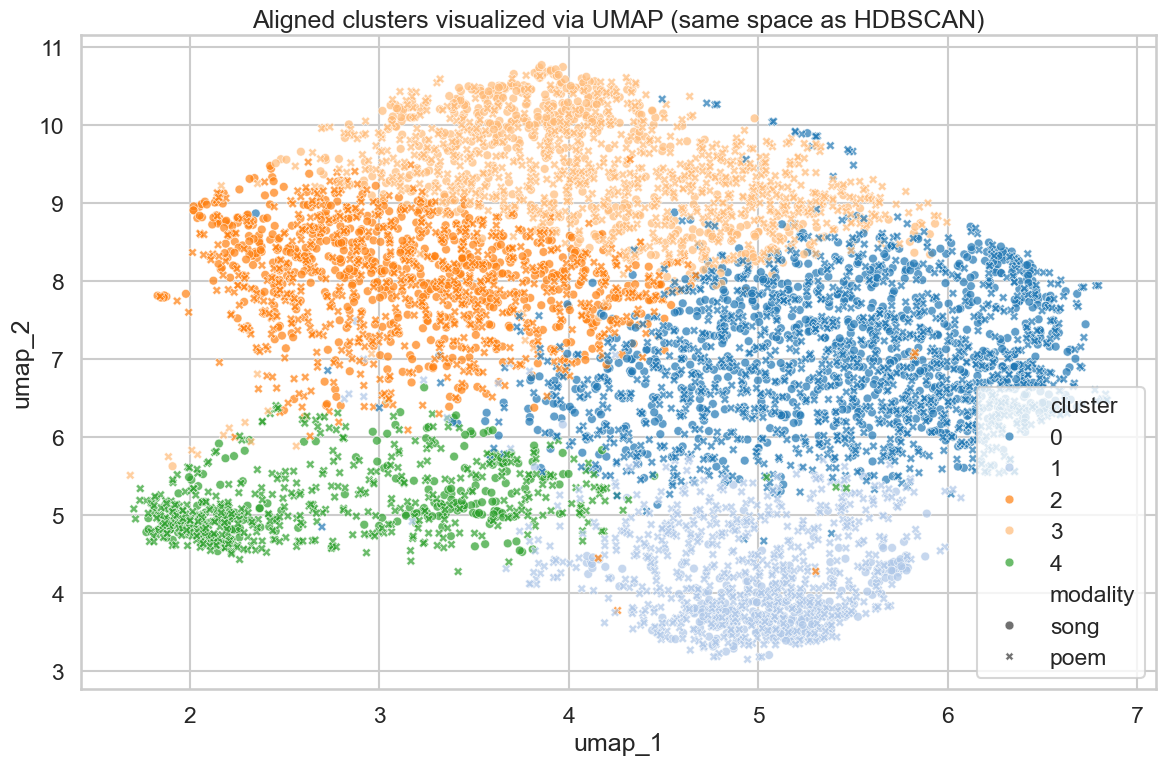

In [56]:

viz_df = combined_df.copy()
viz_df["umap_1"] = aligned_umap[:, 0]
viz_df["umap_2"] = aligned_umap[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x="umap_1",
    y="umap_2",
    hue="cluster",
    style="modality",
    palette="tab20",
    alpha=0.7,
    s=40,
)
plt.title("Aligned clusters visualized via UMAP (same space as HDBSCAN)")
plt.tight_layout()
plt.show()

In [57]:

def display_cluster_samples(cluster_ids, n_songs=3, n_poems=3):
    samples = {}
    for cid in cluster_ids:
        samples[cid] = sample_cluster_examples(combined_df, cid, n_songs=n_songs, n_poems=n_poems)
    return samples

# Use all clusters (not just the top 5) for qualitative inspection
highlight_clusters = cluster_stats.index if not cluster_stats.empty else []
cluster_samples = display_cluster_samples(highlight_clusters, n_songs=5, n_poems=5)
print(f"Collected qualitative samples for clusters: {list(highlight_clusters)}")
cluster_samples

Collected qualitative samples for clusters: [0, 3, 2, 1, 4]


{0: {'songs':                                                 title       creator  \
  0                                       Father Figure  Taylor Swift   
  4                                 The Fate of Ophelia  Taylor Swift   
  13  The Fate of Ophelia - Alone In My Tower Acoust...  Taylor Swift   
  62                                   Baptized In Fear    The Weeknd   
  69                                      Give Me Mercy    The Weeknd   
  
      popularity  
  0         94.0  
  4        100.0  
  13         0.0  
  62        71.0  
  69        63.0  ,
  'poems':                                                   title              creator  \
  3001                                An Exile's Farewell  Adam Lindsay Gordon   
  3002                     I Have A Rendezvous With Death          Alan Seeger   
  3005                                The Deserted Garden          Alan Seeger   
  3014  Epitaph. on General Henry Withers, in Westmins...       Alexander Pope   
  3015   Epit

In [58]:

# Compute sentiment with VADER using a chunked loop and a progress bar.
# Sentiment is computed on lightly normalized text so stop-word tweaks can happen later.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
import re

analyzer = SentimentIntensityAnalyzer()
texts = combined_df["text"].fillna("").astype(str)

def normalize_for_sentiment(text: str) -> str:
    """Basic cleanup for VADER without dropping stop words."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\[.*?\]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

batch_size = 1000
n = len(texts)

combined_df["sentiment_compound"] = 0.0
combined_df["sentiment_pos"] = 0.0
combined_df["sentiment_neg"] = 0.0

for start in tqdm(range(0, n, batch_size), desc="Scoring sentiment"):
    end = min(start + batch_size, n)
    batch_texts = [normalize_for_sentiment(t) for t in texts.iloc[start:end].tolist()]
    scores = [analyzer.polarity_scores(t) for t in batch_texts]
    combined_df.loc[start:end-1, "sentiment_compound"] = [s.get("compound", 0.0) for s in scores]
    combined_df.loc[start:end-1, "sentiment_pos"] = [s.get("pos", 0.0) for s in scores]
    combined_df.loc[start:end-1, "sentiment_neg"] = [s.get("neg", 0.0) for s in scores]

print(f"Scored {n} rows in batches of {batch_size} (sentiment first, stop words handled later).")


Scoring sentiment:   0%|          | 0/7 [00:00<?, ?it/s]

Scored 6413 rows in batches of 1000 (sentiment first, stop words handled later).


In [59]:

# Manage stop words + build clean_text column for downstream tasks (run after VADER once sentiment is cached).
BASE_DOMAIN_STOPWORDS = {
    "chorus", "verse", "pre", "post", "bridge", "yeah", "ooh", "ah",
    "thy", "thou", "thee", "know", "one", "got", "like", "come", "make", "see",
    "want", "give", "say", "go", "oh", "na", "la", "da", "let", "baby", "woah"
}
EXTRA_STOPWORDS = [
    # Add/remove lowercase tokens here and rerun this cell to refresh clean_text.
]

def build_stopwords(extra_words=None):
    stopwords = {w.lower() for w in ENGLISH_STOP_WORDS}
    stopwords |= {w.lower() for w in BASE_DOMAIN_STOPWORDS}
    stopwords |= {w.lower() for w in EXTRA_STOPWORDS}
    if extra_words:
        stopwords |= {w.lower() for w in extra_words}
    return stopwords

def clean_text_with_stopwords(text: str, stopwords):
    if not isinstance(text, str) or not text.strip():
        return ""
    tokens = re.findall(r"[a-zA-Z']+", text.lower())
    return " ".join(t for t in tokens if t not in stopwords and len(t) > 1)

def refresh_clean_text(extra_words=None, column: str = "clean_text"):
    stopwords = build_stopwords(extra_words)
    combined_df[column] = combined_df["text"].fillna("").astype(str).apply(
        lambda t: clean_text_with_stopwords(t, stopwords)
    )
    return stopwords

STOPLIST = refresh_clean_text()
print(
    f"clean_text column refreshed using {len(STOPLIST)} stop words. "
    "Edit EXTRA_STOPWORDS above and rerun this cell without recomputing sentiment."
)


clean_text column refreshed using 343 stop words. Edit EXTRA_STOPWORDS above and rerun this cell without recomputing sentiment.


In [60]:

CLEAN_TEXT_COLUMN = "clean_text"

def top_tfidf_words(
    df: pd.DataFrame,
    cluster_id: int,
    top_n: int = 12,
    column: str = CLEAN_TEXT_COLUMN,
) -> List[str]:
    if column not in df.columns:
        raise ValueError(
            f"Missing '{column}' column. Run the stop-word cleaning cell before computing keywords."
        )
    texts = df.loc[df["cluster"] == cluster_id, column].astype(str).tolist()
    texts = [t for t in texts if t.strip()]
    if not texts:
        return []
    vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(texts)
    scores = tfidf_matrix.sum(axis=0).A1
    vocab = np.array(vectorizer.get_feature_names_out())
    top_idx = np.argsort(-scores)[:top_n]
    return vocab[top_idx].tolist()

cluster_keywords = []
for cid in highlight_clusters:
    words = top_tfidf_words(combined_df, cid, top_n=10)
    cluster_keywords.append({"cluster": cid, "keywords": ", ".join(words)})
pd.DataFrame(cluster_keywords)


,cluster,keywords
0,0,"love, it, don, ll, just, day, re, time, you, life"
1,3,"don, love, just, it, shall, man, you, ain, re,..."
2,2,"love, don, you, just, it, re, ll, you re, hear..."
3,1,"love, shall, heart, day, sweet, night, earth, ..."
4,4,"que, love, lyrics, te, el, yo, contributors, e..."


In [61]:
# Define a small emotion lexicon and a helper to compute per-text emotion scores
EMOTION_LEXICON = {
    "joy": {"happy", "joy", "delight", "glad", "smile", "love", "laugh", "sunny"},
    "sadness": {"sad", "sorrow", "tear", "lonely", "mourning", "grief", "weep", "cry"},
    "anger": {"angry", "rage", "hate", "fury", "wrath", "mad"},
    "fear": {"fear", "scared", "afraid", "panic", "terror", "dread"},
    "surprise": {"surprise", "surprised", "wow", "astonish", "amazed"},
    "trust": {"trust", "faith", "believe", "true", "safe"},
    "disgust": {"disgust", "dislike", "gross", "nausea", "repulsed"},
    "anticipation": {"expect", "hope", "anticipate", "waiting", "eager"},
}


def emotion_vector(text: str) -> Dict[str, float]:
    """
    Return a dict mapping each emotion to the fraction of tokens in `text` that matched that emotion's lexicon.
    Safe to run repeatedly; returns zeros for empty/non-string input.
    """
    if not isinstance(text, str) or not text.strip():
        return {e: 0.0 for e in EMOTION_LEXICON.keys()}
    tokens = re.findall(r"[a-zA-Z']+", text.lower())
    if not tokens:
        return {e: 0.0 for e in EMOTION_LEXICON.keys()}
    total = len(tokens)
    scores = {}
    for emotion, lex in EMOTION_LEXICON.items():
        count = sum(1 for t in tokens if t in lex)
        scores[emotion] = float(count) / float(total)
    return scores


In [62]:

RUN_EMOTION_LEXICON = False
RUN_WORDCLOUDS = True
RUN_KEYWORDS = True


In [63]:
# Recompute emotion-derived columns and sentiment_summary to ensure downstream cells have the data they expect
# Safe to run multiple times: assigns/overwrites the same columns
if RUN_EMOTION_LEXICON:
    emotion_df = combined_df["clean_text"].apply(emotion_vector).apply(pd.Series)
    for col in emotion_df.columns:
        combined_df[col] = emotion_df[col]
else:
    # If not running the emotion lexicon, ensure no emotion columns linger
    emotion_cols = []
    try:
        emotion_cols = list(EMOTION_LEXICON.keys())
    except Exception:
        emotion_cols = []
    for col in emotion_cols:
        if col in combined_df.columns:
            combined_df.drop(columns=[col], inplace=True)

# Ensure sentiment columns exist (they may have been created above when vader is available)
for c in ["sentiment_compound", "sentiment_pos", "sentiment_neg"]:
    if c not in combined_df.columns:
        combined_df[c] = 0.0

# Compute sentiment_summary grouped by cluster (only labeled rows)
agg_dict = {
    "sentiment_compound": "mean",
    "sentiment_pos": "mean",
    "sentiment_neg": "mean",
}
# Add emotion aggs only if we have them and ran the lexicon
if RUN_EMOTION_LEXICON and 'EMOTION_LEXICON' in globals():
    agg_dict.update({emotion: "mean" for emotion in EMOTION_LEXICON.keys()})

sentiment_summary = (
    combined_df[combined_df["cluster"] >= 0]
    .groupby("cluster")
    .agg(agg_dict)
)

# Quick check output
print("Computed sentiment_summary for clusters (preview):")
print(sentiment_summary.head())

Computed sentiment_summary for clusters (preview):
         sentiment_compound  sentiment_pos  sentiment_neg
cluster                                                  
0                  0.335600       0.138773       0.092477
1                  0.597948       0.157137       0.071898
2                  0.574699       0.174777       0.085191
3                  0.203451       0.139312       0.112916
4                  0.294811       0.121429       0.072553


In [64]:

cluster_themes = []
for entry in cluster_keywords:
    cid = entry["cluster"]
    keywords = entry["keywords"].split(", ") if entry["keywords"] else []
    anchor = ", ".join(keywords[:3]) if keywords else "(insufficient data)"
    cluster_themes.append({
        "cluster": cid,
        "anchor_words": anchor,
        "avg_sentiment": sentiment_summary.get("sentiment_compound", pd.Series()).get(cid, np.nan),
    })
pd.DataFrame(cluster_themes)

,cluster,anchor_words,avg_sentiment
0,0,"love, it, don",0.335600
1,3,"don, love, just",0.203451
2,2,"love, don, you",0.574699
3,1,"love, shall, heart",0.597948
4,4,"que, love, lyrics",0.294811


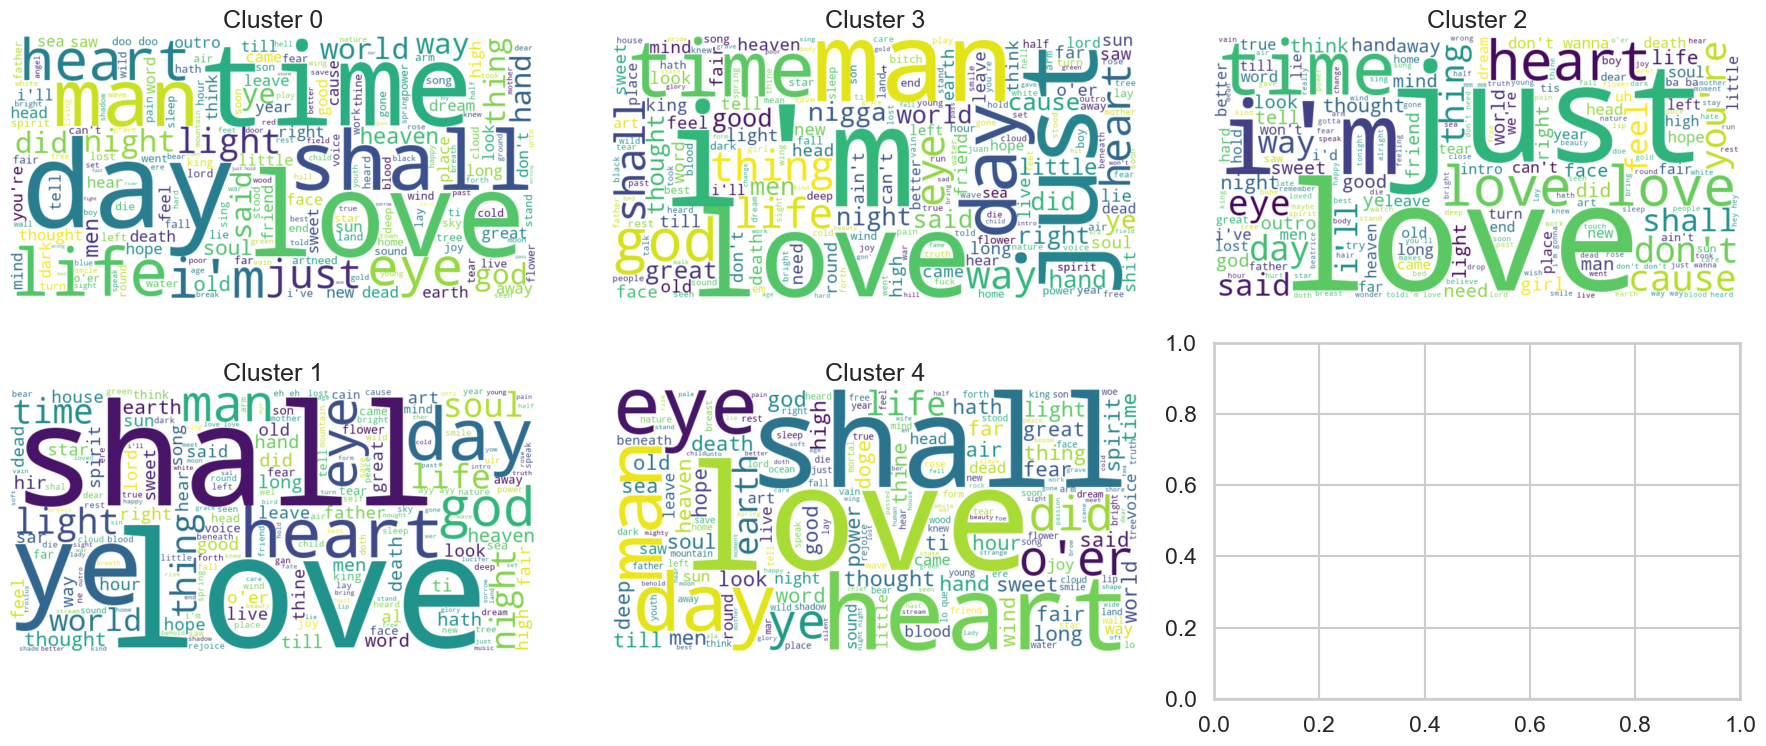

In [65]:

# Wordclouds (optional - toggle with RUN_WORDCLOUDS)
if not RUN_WORDCLOUDS:
    print("Skipping wordcloud generation (RUN_WORDCLOUDS=False)")
else:
    # If you just installed wordcloud in this session, either restart the kernel or
    try:
        if WordCloud is None:
            from wordcloud import WordCloud  # re-import into current kernel
    except Exception:
        # If re-import fails, keep WordCloud as None and report to the user below
        WordCloud = None

    if WordCloud is None:
        print("WordCloud is not available in the current kernel. Run '%pip install wordcloud' and restart the kernel, or re-run this cell after restarting.")
    else:
        # Ensure we have a cleaned text column used by the wordclouds.
        if "clean_text" not in combined_df.columns:
            try:
                STOPLIST = refresh_clean_text()
            except Exception:
                combined_df["clean_text"] = (
                    combined_df["text"].fillna("").astype(str)
                    .str.lower()
                    .str.replace(r"\[.*?\]", " ", regex=True)
                    .str.replace(r"\s+", " ", regex=True)
                    .str.strip()
                )

        if not len(highlight_clusters):
            print("No clusters to highlight.")
        else:
            cols = min(3, len(highlight_clusters))
            rows = int(np.ceil(len(highlight_clusters) / cols))
            fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
            axes = np.atleast_1d(axes).flatten()
            for ax, cid in zip(axes, highlight_clusters):
                text = " ".join(
                    combined_df[combined_df["cluster"] == cid]["clean_text"].astype(str).tolist()
                )
                if not text.strip():
                    ax.axis('off')
                    continue
                try:
                    stopwords_arg = STOPLIST if 'STOPLIST' in globals() else None
                    cloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords_arg).generate(text)
                    ax.imshow(cloud, interpolation='bilinear')
                except Exception as e:
                    ax.text(0.5, 0.5, f"Error generating cloud: {e}", ha='center', wrap=True)
                    ax.axis('off')
                    continue
                ax.axis('off')
                ax.set_title(f"Cluster {cid}")
            plt.tight_layout()


In [66]:

cluster_modality_stats = (
    combined_df.groupby("modality")["cluster"]
    .value_counts()
    .rename("count")
    .reset_index()
)
cluster_modality_stats.head(10)

,modality,cluster,count
0,poem,0,983
1,poem,3,798
2,poem,1,636
3,poem,2,550
4,poem,4,446
5,song,0,993
6,song,2,748
7,song,3,623
8,song,1,348
9,song,4,288


In [67]:

# Global top keywords (most crucial ideas) after cleaning stop words + custom tokens
if RUN_KEYWORDS:
    from sklearn.feature_extraction.text import TfidfVectorizer
    if "clean_text" not in combined_df.columns:
        try:
            STOPLIST = refresh_clean_text()
        except Exception:
            combined_df["clean_text"] = combined_df["text"].fillna("").astype(str)
    texts = combined_df["clean_text"].tolist()
    vectorizer = TfidfVectorizer(max_features=2000, stop_words=list(STOPLIST), ngram_range=(1, 2)) if 'STOPLIST' in globals() else TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    X = vectorizer.fit_transform(texts)
    scores = X.sum(axis=0).A1
    vocab = np.array(vectorizer.get_feature_names_out())
    top_n = 30
    if len(vocab) == 0:
        print("No tokens found after cleaning — check stoplist or input texts.")
    else:
        top_idx = np.argsort(-scores)[:top_n]
        top_terms = vocab[top_idx]
        top_scores = scores[top_idx]
        import pandas as _pd
        print("Top overall keywords (cleaned):")
        _pd.DataFrame({"term": top_terms, "score": top_scores}).reset_index(drop=True)
else:
    print("Skipping global TF-IDF keywords (RUN_KEYWORDS=False)")


Top overall keywords (cleaned):
